In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mglearn
import pandas as pd
import tensorflow.contrib.keras as kr
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

In [2]:
with open('E://cnews/cnews.vocab.txt', encoding='utf8') as file:
    vocabulary_list = [k.strip() for k in file.readlines()]
#读取词表
with open('E://cnews/cnews.train.txt', encoding='utf8') as file:
    line_list = [k.strip() for k in file.readlines()]
    #读取每行
    train_label_list = [k.split()[0] for k in line_list]
    #将标签依次取出
    train_content_list = [k.split(maxsplit=1)[1] for k in line_list]
    #将内容依次取出,此处注意split()选择最大分割次数为1,否则句子被打断.
#同理读取test数据
with open('E://cnews/cnews.test.txt', encoding='utf8') as file:
    line_list = [k.strip() for k in file.readlines()]
    test_label_list = [k.split()[0] for k in line_list]
    test_content_list = [k.split(maxsplit=1)[1] for k in line_list]

In [3]:
word2id_dict = dict(((b, a) for a, b in enumerate(vocabulary_list)))
def content2vector(content_list):
    content_vector_list = []
    for content in content_list:
        content_vector = []
        for word in content:
            if word in word2id_dict:
                content_vector.append(word2id_dict[word])
            else:
                content_vector.append(word2id_dict['<PAD>'])
        content_vector_list.append(content_vector)
    return content_vector_list
train_vector_list = content2vector(train_content_list)
test_vector_list = content2vector(test_content_list)

print(len(train_content_list[0]))
print(len(train_vector_list[:1][0]))
print('************************************')
print(len(test_content_list[0]))
print(len(test_vector_list[:1][0]))

746
746
************************************
1720
1720


In [4]:
vocab_size = 5000  # 词汇表达小
seq_length = 600  # 句子序列长度
num_classes = 10  # 类别数

In [5]:
train_X = kr.preprocessing.sequence.pad_sequences(train_vector_list,600)
test_X = kr.preprocessing.sequence.pad_sequences(test_vector_list,600)
label = LabelEncoder()
train_Y = kr.utils.to_categorical(label.fit_transform(train_label_list),num_classes=num_classes)
test_Y = kr.utils.to_categorical(label.fit_transform(test_label_list),num_classes=num_classes)

In [6]:
X_holder = tf.placeholder(tf.int32,[None,seq_length])
#X的占位符由于句子是由id组成的向量，而id为int类型，
#所以定义x的传入数据为tf.int32类型，
#None表示可以传任意组X，seq_length表示词向量维度。
Y_holder = tf.placeholder(tf.float32,[None,num_classes])
#同理Y占位符向量维度为10，也即num_classes。

In [7]:
embedding_dim = 128  # 词向量维度
num_filters = 256  # 卷积核数目（有多少个卷积核就有多少个feature map）
kernel_size = 8  # 卷积核尺寸
hidden_dim = 128  # 全连接层神经元
dropout_keep_prob = 0.5  # dropout保留比例
learning_rate = 1e-3  # 学习率
batch_size = 64  # 每批训练大小

In [8]:
embedding = tf.get_variable('embedding', [vocab_size, embedding_dim])
#embedding字典维度为5000*128,128为词向量维度
embedding_outputs = tf.nn.embedding_lookup(embedding, X_holder)
#embedding_outputs的维度为(batch_size)64*600*128

In [9]:
conv1 = tf.layers.conv1d(inputs=embedding_outputs,filters=num_filters,kernel_size=kernel_size)
max_pool = tf.reduce_max(conv1,reduction_indices=[1])
full_connect = tf.layers.dense(max_pool,hidden_dim)

In [10]:
full_connect_dropout = tf.contrib.layers.dropout(full_connect,keep_prob=0.5)
full_connect_activate = tf.nn.relu(full_connect_dropout)
full_connect_last = tf.layers.dense(full_connect_activate,num_classes)
predict_y = tf.nn.softmax(full_connect_last)

In [11]:
cross_entry = tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y_holder,logits=full_connect_last)
loss = tf.reduce_mean(cross_entry)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

In [12]:
correct = tf.equal(tf.argmax(Y_holder,1),tf.argmax(predict_y,1))
accuracy = tf.reduce_mean(tf.cast(correct,tf.float32))

In [13]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [14]:
import random
for i in range(5000):
    train_index = random.sample(list(range(len(train_Y))),k=batch_size)
    X = train_X[train_index]
    Y = train_Y[train_index]
    sess.run(train,feed_dict={X_holder:X,Y_holder:Y})
    step = i + 1 
    if step % 100 == 0:
        test_index = random.sample(list(range(len(test_Y))), k=200)
        x = test_X[test_index]
        y = test_Y[test_index]
        loss_value, accuracy_value = sess.run([loss, accuracy], {X_holder:x, Y_holder:y})
        print('step:%d loss:%.4f accuracy:%.4f' %(step, loss_value, accuracy_value))

step:100 loss:1.2979 accuracy:0.6450
step:200 loss:0.4843 accuracy:0.8400
step:300 loss:0.3395 accuracy:0.9100
step:400 loss:0.3620 accuracy:0.9150
step:500 loss:0.1924 accuracy:0.9550
step:600 loss:0.2882 accuracy:0.9250
step:700 loss:0.2156 accuracy:0.9400
step:800 loss:0.2717 accuracy:0.9150
step:900 loss:0.2030 accuracy:0.9350
step:1000 loss:0.2138 accuracy:0.9300
step:1100 loss:0.1234 accuracy:0.9800
step:1200 loss:0.1583 accuracy:0.9500
step:1300 loss:0.2018 accuracy:0.9350
step:1400 loss:0.1951 accuracy:0.9500
step:1500 loss:0.1565 accuracy:0.9500
step:1600 loss:0.1630 accuracy:0.9500
step:1700 loss:0.1407 accuracy:0.9500
step:1800 loss:0.2302 accuracy:0.9550
step:1900 loss:0.1401 accuracy:0.9700
step:2000 loss:0.2931 accuracy:0.9200
step:2100 loss:0.0967 accuracy:0.9650
step:2200 loss:0.2060 accuracy:0.9400
step:2300 loss:0.3226 accuracy:0.9450
step:2400 loss:0.2853 accuracy:0.9200
step:2500 loss:0.2494 accuracy:0.9300
step:2600 loss:0.1150 accuracy:0.9600
step:2700 loss:0.1244

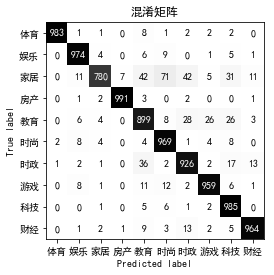

In [15]:
from sklearn.metrics import classification_report
def predictAll(test_X, batch_size=100):
    predict_value_list = []
    for i in range(0, len(test_X), batch_size):
        X = test_X[i: i + batch_size]
        predict_value = sess.run(predict_y, {X_holder:X})
        predict_value_list.extend(predict_value)
    return np.array(predict_value_list)
Y = predictAll(test_X)
y = np.argmax(Y, axis=1)
predict_label_list = label.inverse_transform(y)
score_image = mglearn.tools.heatmap(confusion_matrix(test_label_list, predict_label_list),
                                    xlabel='Predicted label',ylabel='True label',xticklabels=label.classes_,
                                    yticklabels=label.classes_,cmap=plt.cm.gray_r,fmt='%d')
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.title('混淆矩阵')
plt.gca().invert_yaxis()


In [16]:
from sklearn.metrics import precision_recall_fscore_support

def eval_model(y_true, y_pred, labels):
    # 计算每个分类的Precision, Recall, f1, support
    p, r, f1, s = precision_recall_fscore_support(y_true, y_pred)
    # 计算总体的平均Precision, Recall, f1, support
    tot_p = np.average(p, weights=s)
    tot_r = np.average(r, weights=s)
    tot_f1 = np.average(f1, weights=s)
    tot_s = np.sum(s)
    res1 = pd.DataFrame({
        u'Label': labels,
        u'Precision': p,
        u'Recall': r,
        u'F1': f1,
        u'Support': s
    })
    res2 = pd.DataFrame({
        u'Label': ['总体'],
        u'Precision': [tot_p],
        u'Recall': [tot_r],
        u'F1': [tot_f1],
        u'Support': [tot_s]
    })
    res2.index = [999]
    res = pd.concat([res1, res2])
    return res[['Label', 'Precision', 'Recall', 'F1', 'Support']]

eval_model(test_label_list, predict_label_list, label.classes_)

,Label,Precision,Recall,F1,Support
0,体育,0.996957,0.983,0.989930,1000
1,娱乐,0.962451,0.974,0.968191,1000
2,家居,0.975000,0.780,0.866667,1000
3,房产,0.991992,0.991,0.991496,1000
4,教育,0.878788,0.899,0.888779,1000
5,时尚,0.896392,0.969,0.931283,1000
6,时政,0.910521,0.926,0.918195,1000
7,游戏,0.956132,0.959,0.957564,1000
8,科技,0.907834,0.985,0.944844,1000
9,财经,0.969819,0.964,0.966901,1000
